In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.compose             import TransformedTargetForecaster,ForecastingPipeline
from sktime.forecasting.compose             import RecursiveTabularRegressionForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag      import Lag


from sktime.forecasting.compose import AutoEnsembleForecaster
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series

from sktime.transformations.compose             import YtoX, Id, FeatureUnion, IxToX
from sktime.transformations.series.summarize    import WindowSummarizer
from sktime.transformations.series.date         import DateTimeFeatures
from sktime.forecasting.model_selection         import temporal_train_test_split
from sktime.forecasting.compose                 import ForecastingPipeline,make_reduction

import warnings
from sktime.utils.plotting import plot_series

In [6]:
pdf = pd.read_csv("../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-12
y_train, y_test = pdf.iloc[:split], pdf.iloc[split:]

idx = pd.period_range(start=y_train.index[0], end= y_train.index[-1], freq="M")
y_train = pd.Series(y_train.y.values, index=idx)

idx = pd.period_range(start=y_test.index[0], end= y_test.index[-1], freq="M")
y_test = pd.Series(y_test.y.values, index=idx)

In [7]:
#Ridge Regression with a little feature engineering
warnings.filterwarnings("ignore")

pipeline = (
            Differencer([1])
            +Lag([1,2])
            +IxToX()*DateTimeFeatures(ts_freq="M", feature_scope="minimal")
            )

x_train_transformed = pipeline.fit_transform(y_train).dropna()
y_train = y_train[x_train_transformed.index]

forecaster = make_reduction(Ridge(), window_length=12, strategy="recursive")
forecaster.fit(y_train,x_train_transformed)

RecursiveTabularRegressionForecaster(estimator=Ridge(), window_length=12)

In [8]:
idx = pd.period_range(start=y_test.index[0], periods=60, freq="M")
fh = ForecastingHorizon(idx, is_relative=False)

for i,date in enumerate(fh):
    pred_i = forecaster.predict(fh=[i+1],X=x_train_transformed.iloc[-1:])   
    y_train = pd.concat((y_train, pd.Series(pred_i,index=[date])))
    x_train_transformed = pipeline.fit_transform(y_train).dropna()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

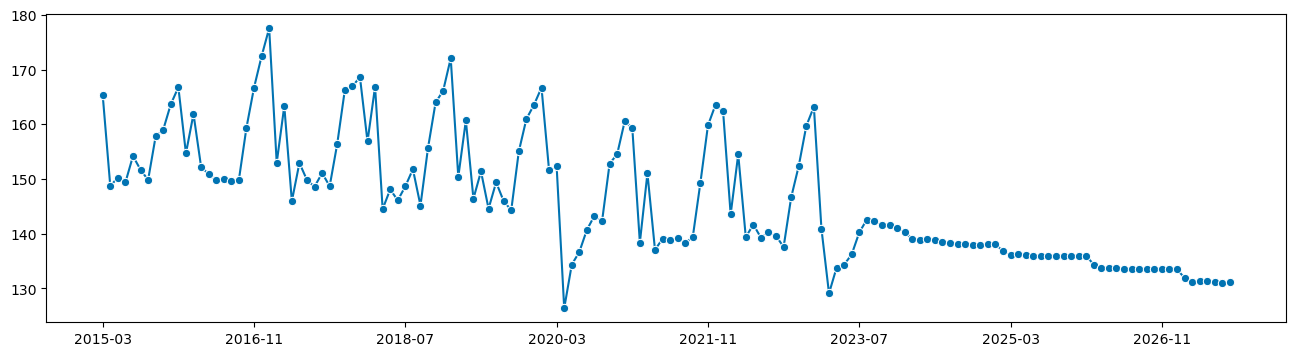

In [9]:
plot_series(y_train)

### How to even to a forecast when glue things together by hand? This doesn't work!